<a href="https://colab.research.google.com/github/VedKate/Vedeneeva_Ekaterina_RT5/blob/main/MPPR/LAB4/Lab4(1_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №4
## Решение оптимизационных задач с помощью генетических алгоритмов


#Варианты для Задания
Варианты и материалы для выполнения лабораторной работы доступны по [ссылке ЯндексДиск](https://disk.yandex.ru/d/0iuecfh0amQGmA)

ШИШКОСУШИЛКА (мое любимое)

## Импортирование необходимых библиотек

In [1]:
import json
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

## Инициализация слов для оптимизации

In [32]:
# ЗДЕСЬ ВПИСЫВАЕТЕ СЛОВА ПО ВАРИАНТУ
messages = [np.random.choice(['шишкосушилка'], size=1000)]

# тут необходимая подготовка, чтобы быстро считать функцию приспособленности
df = pd.DataFrame(dict(msg=np.concatenate(messages)))
df.msg = df.msg.str.lower()
df.msg = df.msg.str.replace('ё', 'е').str.replace(u'\xa0', u' ').str.replace(u'\-', u' ')
df.msg = df.msg.str.replace('[^a-zа-я0-9\s?,.!]', '')

sequence = list(''.join(df[~df.msg.isna()].msg.values))
charmap = np.unique(sequence)

diffs_mask = df[~df.msg.isna()].msg.str.len().cumsum().values.copy()[:-1] - 1
diffs_boolean_mask = np.ones(len(sequence)-1, dtype=np.bool8)
diffs_boolean_mask[diffs_mask] = 0
sequence = list(''.join(df[~df.msg.isna()].msg.values))
bisequence = (pd.Series(sequence[:-1])+pd.Series(sequence[1:]))
BISEQUENCE_FREQS = bisequence.loc[diffs_boolean_mask].value_counts().reset_index()
BISEQUENCE_FREQS.columns = ['biseq', 'freq']
BISEQUENCE_FREQS

<ipython-input-32-90d18edb99bb>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df.msg = df.msg.str.replace('ё', 'е').str.replace(u'\xa0', u' ').str.replace(u'\-', u' ')
<ipython-input-32-90d18edb99bb>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df.msg = df.msg.str.replace('[^a-zа-я0-9\s?,.!]', '')


,biseq,freq
0,ши,2000
1,иш,1000
2,шк,1000
3,ко,1000
4,ос,1000
5,су,1000
6,уш,1000
7,ил,1000
8,лк,1000
9,ка,1000


## Инициализация раскладки клавиатуры

In [33]:
FIRST_ROW = [list('1234567890')]
SECOND_ROW = [list('йцукенгшщзх')]
THIRD_ROW = [list('фывапролджэ')]
FOURTH_ROW = [list('ячсмитьбю')]
FIFTH_ROW = [list(', .\n')]
ROWS = [FIRST_ROW, SECOND_ROW, THIRD_ROW, FOURTH_ROW, FIFTH_ROW]

KEYBINDS = \
[
# first row
[(68,68), (174, 68), (280, 68), (385, 68), (485, 68),
 (585, 68), (685, 68), (790, 68), (905, 68), (1010, 68)],
# second row
[(60, 201),(155, 201),(255, 201),(345, 201),(445, 201),
 (540, 201),(635, 201),(730, 201),(820, 201),(920, 201),(1015, 201)],
# third row
[(60, 350),(155, 350),(255, 350),(345, 350),(445, 350),
 (540, 350),(635, 350),(730, 350),(820, 350),(920, 350),(1015, 350)],
# fourth row
[(155, 500),(255, 500),(345, 500),(445, 500),
 (540, 500),(635, 500),(730, 500),(820, 500),(920, 500)],
# fifth row
[(224, 645),(530, 645),(855, 645),(980, 645)],
]

## Создание раскладки клавиатуры по заданному шаблону

In [34]:
def generate_one():
    # mapper это наша хромосома одной особи
    mapper = {}
    for k, row in enumerate(ROWS):
        for chng, row_lang in enumerate(row):
            for i, s in enumerate(row_lang):
                mapper[s] = (KEYBINDS[k][i][0]//10, KEYBINDS[k][i][1]//10)
    return mapper

## Функция отрисовки раскладки

In [35]:
def plot_keyboard(mapper, generation=0):
    keyboard_img = Image.open('keyboard.png').convert('RGB')
    d = ImageDraw.Draw(keyboard_img)
    font = ImageFont.truetype("Roboto-Bold.ttf", 30)
    for s, v in mapper.items():
        if s=='\n':
            s = 'Ent'
        if s==' ':
            s = '__'
        x, y = v[0]*10, v[1]*10

        d.text((x, y), s, font=font, fill=(255, 255, 255, 255))
    return keyboard_img.resize((500, 250))

Проверим, что отрисовалось правильно

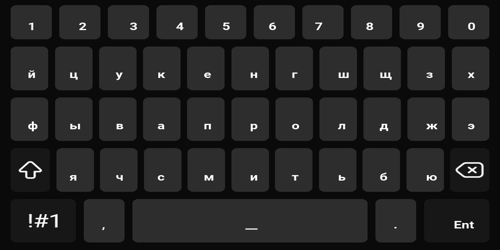

In [36]:
plot_keyboard(generate_one())

## Зададим функцию приспособленности

In [37]:
# функция приспособленности должна минимизировать расстояние,
# требуемое для написания слов
def get_scores(population):
    scores = []
    for new_mapper in population:
        cache = {}
        for i in charmap:
            for j in charmap:
                cache[i+j] = \
                    np.square(np.array(new_mapper.get(i, [-100, -100])) -
                              np.array(new_mapper.get(j, [-100, -100]))).sum()**0.5

        weights = BISEQUENCE_FREQS.biseq.map(cache)
        scores.append(BISEQUENCE_FREQS['freq'].dot(weights))
    return scores

## Зададим функции мутации и скрещивания

In [38]:
def mutation(thingey, mutation_rate=0.05):
    # мутация меняет местами mutation_rate*100 % клавиш друг с другом 
    keys = list(thingey.keys())
    values = list(thingey.values())

    mutation = (np.random.random(size=len(values))<mutation_rate).nonzero()[0]
    swap_index_to = np.random.choice(len(values),
                                     size=len(values),
                                     replace=False)

    new_values = np.array(values)
    for i, j in zip(mutation, swap_index_to[mutation]):
        new_values[[i,j]] = new_values[[j,i]]

    return {k:v for k,v in zip(keys, new_values)}

def crossover(thingeyA, thingeyB):
    # скрещивание между двумя особями заменяет n-ое количество клавиш 1ой особи
    # n-ым количеством клавиш второй особи с сохранением 
    # порядка их встречаемости на раскладке (приоритет сверху-вниз, слево-направо) 
    keysA = list(thingeyA.keys())
    valuesA = list(thingeyA.values())

    keysB = list(thingeyB.keys())
    valuesB = list(thingeyB.values())

    ranksA = np.argsort(keysA)

    keysA = np.array(keysA)[ranksA].copy()
    keysB = np.array(keysB)[ranksA].copy()
    valuesA = np.array(valuesA)[ranksA].copy()
    valuesB = np.array(valuesB)[ranksA].copy()

    offset = np.random.randint(1, max(2, len(valuesA)-1))
    offspring = {k:v for k, v in zip(keysA[:offset], valuesA[:offset])}

    keysO = list(offspring.keys())
    valuesO = list(offspring.values())

    keys_rest = list(filter(lambda k: k not in offspring, thingeyB.keys()))
    valuesRest = valuesA[offset:]
    values = valuesB[offset:]
    ranking = (
        values + 
        (np.max(values)+1)**np.arange(len(values[0])).reshape(1, -1)
               ).sum(axis=1).argsort()
    for k, v in zip(keys_rest, valuesRest[ranking]):
        offspring[k] = v

    # проверка что клавиши не потерялись и не задублировались
    assert set(offspring.keys()
    ).symmetric_difference(thingeyA.keys()).__len__()==0
    assert set(map(tuple, offspring.values())
    ).symmetric_difference(set(map(tuple, thingeyA.values()))).__len__()==0
    return offspring

## Зададим функции генерации начальной популяции и новой

In [39]:
def generate_initial(POPULATION_SIZE, mrate=0.0):
    # первая раскладка неизменённая (может быть лучшее решение)
    population = [mutation(generate_one(), mutation_rate=0.0)]

    # остальные со случайными перестановками клавиш
    for _ in range(max(0, POPULATION_SIZE - 1)):
        population.append(mutation(generate_one(), mutation_rate=mrate))
    return population

def generate_new_population(population, scores,
                            population_size=10,
                            elite_topk=1,
                            random_size=2,
                            ):
    new_population = []
    # элитизм
    for topK in range(elite_topk):
        new_population.append(population[np.argsort(scores)[topK]].copy())
    # трансформация функции приспособленности
    # оценка -> ранг -> экспоненцирование -> нормализация
    scores_ranks = scores.copy()
    for i, r in enumerate(np.argsort(scores)):
        scores_ranks[r] = i
    scores_ranks = np.exp(-np.array(scores_ranks)/len(scores_ranks)*4)
    scores_ranks /= scores_ranks.sum()

    # рулеточный отбор особей для продолжения потомства
    for _ in range(max(0, population_size - elite_topk - random_size)):
        parentA, parentB = np.random.choice(len(scores), size=2, replace=True, p=scores_ranks)
        new_population.append(mutation(crossover(population[parentA], population[parentB])))
    # добавление особей со стороны
    for _ in range(max(0, random_size)):
        if np.random.random() < 0.5:
            # полностью случайная раскладка с перемешанными клавишами
            new_population.append(mutation(generate_one(), 1.0))
        else:
            # случайно изменённая лучшая (hill climbing)
            new_population.append(mutation(new_population[0]))

    return new_population

## Осуществим оптимизацию раскладки клавиатуры с помощью генетического алгоритма

In [40]:
POPULATION_SIZE = 200
ELITISM_TOPK = 10
RANDOM_SIZE = 100
NUM_GENERATIONS = 25
NUM_RESTARTS = 10

bscore = np.inf
stats = []
for restart in range(NUM_RESTARTS):
    print('Рестарт: %d' % (restart+1))
    population = generate_initial(POPULATION_SIZE, 1.0)
    for generation in range(NUM_GENERATIONS):
        scores = get_scores(population)
        population = generate_new_population(population, scores,
                                            POPULATION_SIZE,
                                            ELITISM_TOPK,
                                            RANDOM_SIZE)
        stats.append((generation, min(scores), max(scores), np.mean(scores)))
        if min(scores) < bscore:
            bscore = min(scores)
            bimg = plot_keyboard(population[0], generation)
            print(('Поколение: %d\tЛучшее расстояние: %.1f\t'
                   'Худшее расстояние: %.1f\t'
                   'Среднее расстояние в популяции: %.1f')%stats[-1])

Рестарт: 1
Поколение: 0	Лучшее расстояние: 237046.9	Худшее расстояние: 724216.9	Среднее расстояние в популяции: 472340.6
Поколение: 2	Лучшее расстояние: 219777.4	Худшее расстояние: 803176.3	Среднее расстояние в популяции: 408207.8
Поколение: 3	Лучшее расстояние: 209259.1	Худшее расстояние: 795746.6	Среднее расстояние в популяции: 413735.1
Поколение: 4	Лучшее расстояние: 197683.1	Худшее расстояние: 798529.1	Среднее расстояние в популяции: 395213.6
Поколение: 5	Лучшее расстояние: 179993.5	Худшее расстояние: 834241.5	Среднее расстояние в популяции: 392844.8
Поколение: 8	Лучшее расстояние: 179074.0	Худшее расстояние: 681251.0	Среднее расстояние в популяции: 374679.9
Поколение: 9	Лучшее расстояние: 176372.8	Худшее расстояние: 717544.2	Среднее расстояние в популяции: 379310.6
Поколение: 10	Лучшее расстояние: 173137.6	Худшее расстояние: 679890.5	Среднее расстояние в популяции: 377008.7
Поколение: 14	Лучшее расстояние: 170185.3	Худшее расстояние: 735277.7	Среднее расстояние в популяции: 377987

## Отобразим лучшую раскладку

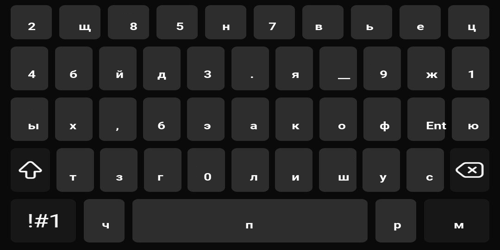

In [41]:
bimg